In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys 
installation_path = "/content/drive/MyDrive/Colab_Installations_V2"
# The path is being modified so that everything installed in the installation path can now be used without re-installing (in this case, I just need biopython)
sys.path.append(installation_path)
protein_mpnn_path = "/content/drive/MyDrive/Protein_MPNN_Digging/ProteinMPNN/vanilla_proteinmpnn"
sys.path.insert(0,protein_mpnn_path)

Mounted at /content/drive


In [ ]:
# ! pip install --upgrade --target=$installation_path dataframe_image

In [ ]:
%cd /content/drive/MyDrive/Protein_MPNN_Digging

/content/drive/MyDrive/Protein_MPNN_Digging


In [ ]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
from Bio.PDB.Polypeptide import *
from Bio.PDB import *
import random

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import Ridge
from scipy.stats import entropy
from scipy.special import softmax
from scipy.special import kl_div
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

In [ ]:
with open("S_2648_full_feature_dict.pickle","rb") as f:
    S_2648_two_level_dict = pickle.load(f)
with open("S_921_full_feature_dict.pickle","rb") as f:
    S_921_two_level_dict = pickle.load(f)
with open("S_669_full_feature_dict.pickle","rb") as f:
    S_669_two_level_dict = pickle.load(f)
with open("Ssym_full_feature_dict.pickle","rb") as f:
    Ssym_two_level_dict = pickle.load(f)

In [ ]:
list_two_level_dict = [S_2648_two_level_dict,S_921_two_level_dict,S_669_two_level_dict,Ssym_two_level_dict]
list_dataset_names = ["S_2648","S_921","S_669","Ssym"]

In [ ]:
list_mapping_dict = []
list_proteins_to_skip = []

for name in list_dataset_names:
    mapping_dict = {}
    pdbDirectory = f"/content/drive/MyDrive/ACCRE_PyRun_Setup/{name}_PDB_Files"
    parser = PDBParser(QUIET=True)
    # some proteins need to be skipped for now due to ICODE related discrapency
    proteins_to_skip = []

    for filename in tqdm(os.listdir(pdbDirectory)):
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        inner_dict = {}
        outer_key = filename.split(".")[0]
        skip_flag = False
        # single chain-assumption in action again
        for chain in model:
            for i,residue in enumerate(chain):
                inner_key = f"{three_to_one(residue.get_resname())}{residue.get_id()[1]}"
                if inner_key not in inner_dict:
                    inner_dict[inner_key] = i
                else:
                    # For "2immA:N31" and "1lveA:S27", I have been fucked
                    # Need to think whether this will effect other positions or I can just avoid these two-protein related mutations for now?
                    # Let me just avoid these two proteins for now
                    print("YOU HAVE JUST BEEN FUCKED BY ICODE")
                    print(f"{outer_key}:{inner_key}")
                    skip_flag = True
        # The ICODE related problematic proteins will not be considered for now
        if not skip_flag:
            mapping_dict[outer_key] = inner_dict
        else:
            proteins_to_skip.append(outer_key)
    list_proteins_to_skip.append(proteins_to_skip)
    list_mapping_dict.append(mapping_dict)

  0%|          | 0/131 [00:00<?, ?it/s]

YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

In [ ]:
# Create the six numpy arrays here, and then perform training on the next cell
X_2648 = []
y_2648 = []
X_921 = []
y_921 = []
X_669 = []
y_669 = []
X_Ssym = []
y_Ssym = []

# This list will correspond to the "list_mapping_dict,list_dataset_names,list_two_level_dict,list_proteins_to_skip" lists in the above cells, 
# and hold (X,y) tuples corresponding to the three datasets in the same order as those lists
# currently, I intend to train, and test the model on "mut_wild_predictions","entropy_predictions", "neighbor_energy_change_predictions", "neighbor_forward_KL_predictions", 
# and "neighbor_backward_KL_predictions" 
# fourth and fifth features can probably be reduced to one feature by (0.5*fourth_feature+0.5*fifth_feature) since both of them are extremely correlated
list_X = [X_2648,X_921,X_669,X_Ssym]
list_y = [y_2648,y_921,y_669,y_Ssym]

#######
alpha_tok = "ACDEFGHIKLMNPQRSTVWYX"
aa_1_N = {a:n for n,a in enumerate(alpha_tok)}
for X,y,two_level_dict,mapping_dict,proteins_to_skip in zip(list_X,list_y,list_two_level_dict,list_mapping_dict,list_proteins_to_skip):
    for prot,muts in two_level_dict.items():
        if prot not in proteins_to_skip:
            try:
                cur_map_dict = mapping_dict[prot]
            except:
                continue
            for mut in muts:
                # adding the label to "y" at first
                y.append(mut["ddg"])

                # This "cur_X" will hold the features for the current mutation under-processing in the current inner loop iteration
                cur_X = []
                
                ### first feature addition (mutation position energy-change)
                center_mut_wild_energy = mut["center_mut_wild_energy"]
                cur_X.append(center_mut_wild_energy)
                ### first feature addition
                
                ### second feature addition (mutation position entropy)
                center_entropy = mut["center_entropy"]
                cur_X.append(center_entropy)
                ### second feature addition

                ### third feature addition (neighbor wildtype energy-change due to mutation)
                weighted_neighbor_energy_changes = mut["V2_backward_weighted_neighbor_energy_changes"]
                cur_X.append(weighted_neighbor_energy_changes)
                ### third feature addition

                ### fourth feature addition (forward KL of neighbors due to mutation at center)
                weighted_neighbor_forward_KL = mut["weighted_neighbor_forward_KL"]
                cur_X.append(weighted_neighbor_forward_KL)
                ### fourth feature addition

                ### fifth feature addition (backward KL of neighbors due to mutation at center)
                weighted_neighbor_backward_KL = mut["V2_backward_weighted_neighbor_backward_KL"]
                cur_X.append(weighted_neighbor_backward_KL)
                ### fifth feature addition

                ### sixth feature(PSSM features) addition
                pssm_feature = mut["wild_pssm"]-mut["alternate_pssm"]
                cur_X.append(pssm_feature)
                ### adding the two PSSM features

                ### seventh feature addition (entropy-change of neighbors due to mutation at center)
                weighted_neighbor_entropy_changes = mut["V2_backward_weighted_neighbor_entropy_changes"]
                cur_X.append(weighted_neighbor_entropy_changes)
                ### seventh feature addition 

                ### eigth feature addition (w/m attention change)
                center_neighbor_weight_check_w_m = mut["center_neighbor_weight_check_w_m"]
                cur_X.append(center_neighbor_weight_check_w_m)
                ### eigth feature addition 

                X.append(np.array(cur_X))

In [ ]:
S_2648_X = np.array(list_X[0])
S_2648_y = np.array(list_y[0])
S_921_X = np.array(list_X[1])
S_921_y = np.array(list_y[1])
S_669_X = np.array(list_X[2])
S_669_y = np.array(list_y[2])
# Flipping the signs of the experimental DDG values in S_669_y to get coherent correlations (positive and higher is better)
S_669_y = S_669_y * (-1)
Ssym_X = np.array(list_X[3])
Ssym_y = np.array(list_y[3])

In [184]:
print("S_921 single-feature correlations at a glance")
print(pearsonr(S_921_y,S_921_X[:,0]))
print(pearsonr(S_921_y,S_921_X[:,1]))
print(pearsonr(S_921_y,S_921_X[:,2]))
print(pearsonr(S_921_y,S_921_X[:,3]))
print(pearsonr(S_921_y,S_921_X[:,4]))
print(pearsonr(S_921_y,S_921_X[:,5]))
print(pearsonr(S_921_y,S_921_X[:,6]))
print(pearsonr(S_921_y,S_921_X[:,7]))
print(".............................................")

print("S_669 single-feature correlations at a glance")
print(pearsonr(S_669_y,S_669_X[:,0]))
print(pearsonr(S_669_y,S_669_X[:,1]))
print(pearsonr(S_669_y,S_669_X[:,2]))
print(pearsonr(S_669_y,S_669_X[:,3]))
print(pearsonr(S_669_y,S_669_X[:,4]))
print(pearsonr(S_669_y,S_669_X[:,5]))
print(pearsonr(S_669_y,S_669_X[:,6]))
print(pearsonr(S_669_y,S_669_X[:,7]))
print(".............................................")

print("S_2648 single-feature correlations at a glance")
print(pearsonr(S_2648_y,S_2648_X[:,0]))
print(pearsonr(S_2648_y,S_2648_X[:,1]))
print(pearsonr(S_2648_y,S_2648_X[:,2]))
print(pearsonr(S_2648_y,S_2648_X[:,3]))
print(pearsonr(S_2648_y,S_2648_X[:,4]))
print(pearsonr(S_2648_y,S_2648_X[:,5]))
print(pearsonr(S_2648_y,S_2648_X[:,6]))
print(pearsonr(S_2648_y,S_2648_X[:,7]))
print(".............................................")

print("Ssym single-feature correlations at a glance")
print(pearsonr(Ssym_y,Ssym_X[:,0]))
print(pearsonr(Ssym_y,Ssym_X[:,1]))
print(pearsonr(Ssym_y,Ssym_X[:,2]))
print(pearsonr(Ssym_y,Ssym_X[:,3]))
print(pearsonr(Ssym_y,Ssym_X[:,4]))
print(pearsonr(Ssym_y,Ssym_X[:,5]))
print(pearsonr(Ssym_y,Ssym_X[:,6]))
print(pearsonr(Ssym_y,Ssym_X[:,7]))
print(".............................................")

S_921 single-feature correlations at a glance
(0.6441949275101646, 4.197628384942669e-109)
(0.2558421609543604, 3.1365846164886655e-15)
(0.4246158386026147, 1.3026594673519176e-41)
(0.3134337286123688, 1.9228114031719706e-22)
(0.3823972745976371, 1.9347320512062632e-33)
(0.5145587134119901, 2.1316560964554222e-63)
(0.45208768082866796, 1.369524145760863e-47)
(-0.117496038620017, 0.0003524985138175584)
.............................................
S_669 single-feature correlations at a glance
(0.33765558573837523, 1.772522028540666e-18)
(0.26048284702580865, 2.3531867527057347e-11)
(0.1840383857546425, 2.8761043604547314e-06)
(0.33492161096653633, 3.4543143279502605e-18)
(0.35931713121897724, 7.056787490196558e-21)
(0.1760175004428737, 7.741516443498937e-06)
(0.17517328176139838, 8.570165531743268e-06)
(-0.013977688826732376, 0.724551365126908)
.............................................
S_2648 single-feature correlations at a glance
(0.5046657755393072, 2.4008447333492008e-169)
(0.35

In [ ]:
# Let us try to add some reverse mutants quickly
S_2648_X_aug = []
S_2648_y_aug = []
for X,y in zip(S_2648_X,S_2648_y):
    S_2648_X_aug.append(X)
    S_2648_X_aug.append(-1*X)
    S_2648_y_aug.append(y)
    S_2648_y_aug.append(-1*y)
S_2648_X_aug = np.array(S_2648_X_aug)
S_2648_y_aug = np.array(S_2648_y_aug)

S_921_X_aug = []
S_921_y_aug = []
for X,y in zip(S_921_X,S_921_y):
    S_921_X_aug.append(X)
    S_921_X_aug.append(-1*X)
    S_921_y_aug.append(y)
    S_921_y_aug.append(-1*y)
S_921_X_aug = np.array(S_921_X_aug)
S_921_y_aug = np.array(S_921_y_aug)

S_669_X_aug = []
S_669_y_aug = []
for X,y in zip(S_669_X,S_669_y):
    S_669_X_aug.append(X)
    S_669_X_aug.append(-1*X)
    S_669_y_aug.append(y)
    S_669_y_aug.append(-1*y)
S_669_X_aug = np.array(S_669_X_aug)
S_669_y_aug = np.array(S_669_y_aug)

Ssym_X_aug = []
Ssym_y_aug = []
for X,y in zip(Ssym_X,Ssym_y):
    Ssym_X_aug.append(X)
    Ssym_X_aug.append(-1*X)
    Ssym_y_aug.append(y)
    Ssym_y_aug.append(-1*y)
Ssym_X_aug = np.array(Ssym_X_aug)
Ssym_y_aug = np.array(Ssym_y_aug)

In [166]:
print("S_921 single-feature correlations at a glance")
print(pearsonr(S_921_y_aug,S_921_X_aug[:,0]))
print(pearsonr(S_921_y_aug,S_921_X_aug[:,1]))
print(pearsonr(S_921_y_aug,S_921_X_aug[:,2]))
print(pearsonr(S_921_y_aug,S_921_X_aug[:,3]))
print(pearsonr(S_921_y_aug,S_921_X_aug[:,4]))
print(pearsonr(S_921_y_aug,S_921_X_aug[:,5]))
print(pearsonr(S_921_y_aug,S_921_X_aug[:,6]))
print(".............................................")

print("S_669 single-feature correlations at a glance")
print(pearsonr(S_669_y_aug,S_669_X_aug[:,0]))
print(pearsonr(S_669_y_aug,S_669_X_aug[:,1]))
print(pearsonr(S_669_y_aug,S_669_X_aug[:,2]))
print(pearsonr(S_669_y_aug,S_669_X_aug[:,3]))
print(pearsonr(S_669_y_aug,S_669_X_aug[:,4]))
print(pearsonr(S_669_y_aug,S_669_X_aug[:,5]))
print(pearsonr(S_669_y_aug,S_669_X_aug[:,6]))
print(".............................................")

print("S_2648 single-feature correlations at a glance")
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,0]))
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,1]))
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,2]))
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,3]))
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,4]))
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,5]))
print(pearsonr(S_2648_y_aug,S_2648_X_aug[:,6]))
print(".............................................")

print("Ssym single-feature correlations at a glance")
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,0]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,1]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,2]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,3]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,4]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,5]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,6]))
print(pearsonr(Ssym_y_aug,Ssym_X_aug[:,7]))
print(".............................................")

S_921 single-feature correlations at a glance
(0.7114135041226424, 3.6107953953724694e-284)
(-0.27350177750301485, 5.821378024579929e-33)
(0.5067758213429064, 9.322609047108007e-121)
(0.48030336788044786, 6.305986289331493e-107)
(0.5240659562681848, 1.8028365862171377e-130)
(0.6156235934491623, 1.345636338382816e-192)
(0.5332430995193724, 7.37191376496228e-136)
.............................................
S_669 single-feature correlations at a glance
(0.5456054040585018, 7.117694787118454e-100)
(-0.38638061377980293, 1.0744421851930066e-46)
(0.34496659459123846, 5.7286162139765435e-37)
(0.5524049291276631, 7.769039750328612e-103)
(0.563706151754503, 6.510237487633929e-108)
(0.4672168708556927, 3.5323499573278284e-70)
(0.3290837042695034, 1.317571430106729e-33)
.............................................
S_2648 single-feature correlations at a glance
(0.6991317965087939, 0.0)
(-0.4269343725077419, 3.4111328539872277e-231)
(0.4479992668909575, 3.82800643148893e-257)
(0.532276687571369

In [167]:
pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["C"]])[0]

-0.24733060335449503

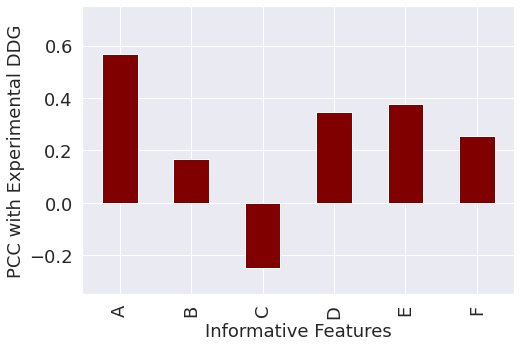

In [197]:
# let us draw some correlation bargraphs here for each of the datasets with the 6 features (A,B,C,D,E,F)
import matplotlib.pyplot as plt
import matplotlib as mpl

# let us populate the arrays "methods" and "vals" automatically here
feature_to_index_map = {"A":0,
                        "B":4,
                        "C":7,
                        "D":2,
                        "E":6,
                        "F":5}

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
# ax.grid(False)
methods = ['A','B','C','D','E',"F"]
vals = [pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["A"]])[0],pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["B"]])[0],
        pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["C"]])[0],pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["D"]])[0],
        pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["E"]])[0],pearsonr(Ssym_y,Ssym_X[:,feature_to_index_map["F"]])[0]]
plt.ylabel("PCC with Experimental DDG",fontsize=18)
plt.xlabel("Informative Features",fontsize=18)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.ylim(-0.35,0.75)
ax.bar(methods,vals,color="maroon",width=0.5)
mpl.rcParams['grid.color'] = 'white'
plt.show()

In [ ]:
# Now, traing linear regression on S_2648, and test on S_921 and S_669
# the setting reg = Ridge(alpha=0.2,normalize=True).fit(S_2648_X_aug[:,[0,2,4,5]], S_2648_y_aug) seems quite good
# Ridge(alpha=0.25,normalize=True).fit(S_2648_X_aug[:,[0,2,4,5]], S_2648_y_aug) is also good
# Ridge(alpha=0,normalize=True) is also not bad
# (center_mut_wild_energy,weighted_neighbor_energy_changes,weighted_neighbor_backward_KL,PSSM) seems the best combination for now
# also, ridge with alpha=0.4 seems the best for now (specially, for S_669)
# also, ridge with alpha=0.9, and (center_mut_wild_energy,weighted_neighbor_backward_KL,PSSM) gets the maximum for S_669 while reducing for S_sym
reg = Ridge(alpha=0,normalize=True,max_iter=5000000).fit(S_2648_X_aug[:,[0,4,5,7]], S_2648_y_aug)
print(pearsonr(S_2648_y,reg.predict(S_2648_X[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,reg.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,reg.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,reg.predict(Ssym_X_aug[:,[0,4,5,7]])))

(0.5326576324947646, 5.836728581748048e-192)
(0.7500175960777788, 0.0)
(0.5994093570242581, 2.5920163633370395e-125)
(0.7284501445308078, 4.03294929660826e-114)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


In [ ]:
print(reg.coef_)
print(reg.intercept_)

[ 0.2857634   0.02814324  0.0360316  -0.00292185]
0.0


In [160]:
# Now, traing linear regression on S_2648, and test on S_921 and S_669
# rf = RandomForestRegressor(min_samples_split=62).fit(S_2648_X_aug[:,[0,2,4,5,7]],S_2648_y_aug)
# rf = RandomForestRegressor(min_samples_split=84).fit(S_2648_X_aug[:,[0,2,4,5,7]],S_2648_y_aug) [not bad]
# rf = RandomForestRegressor(min_samples_split=84).fit(S_2648_X_aug[:,[0,2,4,7]],S_2648_y_aug) [not bad]
# seems like (0,2,4,5, and 7 are worth keeping with RF)
# rf = RandomForestRegressor(min_samples_split=22,n_estimators=300,max_samples=0.2).fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug) [great for balanced performance on everything]
# rf = RandomForestRegressor(min_samples_split=22,n_estimators=300,max_samples=0.5).fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug) [a bit better for Ssym, a bit worse for S_669]
# rf = RandomForestRegressor(min_samples_split=22,n_estimators=300,max_samples=0.5).fit(S_2648_X_aug[:,[0,4,7]],S_2648_y_aug) [worth reporting without PSSM, only S_921 goes down significantly]
# rf = RandomForestRegressor(min_samples_split=18,n_estimators=300,max_samples=0.5).fit(S_2648_X_aug[:,[0,4,7]],S_2648_y_aug) [seems good without PSSM]
# "max_samples=0.2" seems like a great parameter for many cases, most probably, that type of diversity is needed
# rf = RandomForestRegressor(min_samples_split=25,n_estimators=300,max_samples=0.2).fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug) [another cool parameter setting]
# rf = RandomForestRegressor(min_samples_split=84,n_estimators=300,max_samples=0.2).fit(S_2648_X_aug[:,[0,2,4,6,7]],S_2648_y_aug)
# print(pearsonr(S_2648_y,rf.predict(S_2648_X[:,[0,2,4,6,7]])))
# print(pearsonr(S_921_y_aug,rf.predict(S_921_X_aug[:,[0,2,4,6,7]])))
# print(pearsonr(S_669_y_aug,rf.predict(S_669_X_aug[:,[0,2,4,6,7]])))
# print(pearsonr(Ssym_y_aug,rf.predict(Ssym_X_aug[:,[0,2,4,6,7]])))

# rf = RandomForestRegressor(min_samples_split=12,n_estimators=300,max_samples=0.2).fit(S_2648_X_aug[:,[0,4,5]],S_2648_y_aug) [not bad with three most important features]
# rf = RandomForestRegressor(min_samples_split=12,n_estimators=300,max_samples=0.2).fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug) [cool, good, awesome stuff]
# rf = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2).fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug) [cool as fuck good shit]
rf_5 = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_5.predict(S_2648_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,rf_5.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,rf_5.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,rf_5.predict(Ssym_X_aug[:,[0,4,5,7]])))
rf_5.feature_importances_

(0.8131719592997405, 0.0)
(0.7431047478975888, 2e-323)
(0.6025256083885061, 6.157455454466751e-127)
(0.7530162639375351, 4.3502833560946976e-126)


array([0.40516653, 0.25495239, 0.13218457, 0.20769651])

In [159]:
rf_3 = RandomForestRegressor(min_samples_split=3,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_3.predict(S_2648_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,rf_3.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,rf_3.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,rf_3.predict(Ssym_X_aug[:,[0,4,5,7]])))
rf_3.feature_importances_

(0.8241923094646503, 0.0)
(0.7439050884466478, 0.0)
(0.6016984251696524, 1.6683585723445468e-126)
(0.7574674830978346, 2.080578228308255e-128)


array([0.3984581 , 0.24565498, 0.13539143, 0.22049549])

In [158]:
rf_25 = RandomForestRegressor(min_samples_split=25,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_25.predict(S_2648_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,rf_25.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,rf_25.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,rf_25.predict(Ssym_X_aug[:,[0,4,5,7]])))
rf_25.feature_importances_

(0.7704858741195095, 0.0)
(0.7457098010708739, 0.0)
(0.6030857658759091, 3.129923252478255e-127)
(0.7467483494451822, 6.65407446161965e-123)


array([0.45856132, 0.24355987, 0.11149965, 0.18637916])

In [157]:
rf_45 = RandomForestRegressor(min_samples_split=45,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_45.predict(S_2648_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,rf_45.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,rf_45.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,rf_45.predict(Ssym_X_aug[:,[0,4,5,7]])))
rf_45.feature_importances_

(0.7565497919646782, 0.0)
(0.7423220072805928, 2.67e-322)
(0.6002055151263626, 1.000851325481631e-125)
(0.7459534458544852, 1.6605325869286838e-122)


array([0.47255185, 0.24098784, 0.11269332, 0.17376699])

In [156]:
rf_75 = RandomForestRegressor(min_samples_split=75,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_75.predict(S_2648_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,rf_75.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,rf_75.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,rf_75.predict(Ssym_X_aug[:,[0,4,5,7]])))
rf_75.feature_importances_

(0.7446685225537832, 0.0)
(0.7342401991221972, 8.205179537406e-312)
(0.5989029462777395, 4.741331217748633e-125)
(0.740568817709326, 7.448391199578234e-120)


array([0.45997836, 0.24167998, 0.11239832, 0.18594334])

In [146]:
rf_2 = RandomForestRegressor(min_samples_split=2,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,4,5,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_2.predict(S_2648_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,rf_2.predict(S_921_X_aug[:,[0,4,5,7]])))
print(pearsonr(S_669_y_aug,rf_2.predict(S_669_X_aug[:,[0,4,5,7]])))
print(pearsonr(Ssym_y_aug,rf_2.predict(Ssym_X_aug[:,[0,4,5,7]])))
rf_2.feature_importances_

(0.8299175136446364, 0.0)
(0.7415753495330848, 2.59e-321)
(0.5986807216876371, 6.177875346408829e-125)
(0.7586799408062275, 4.7579812210258565e-129)


array([0.39748006, 0.26267886, 0.13978267, 0.20005841])

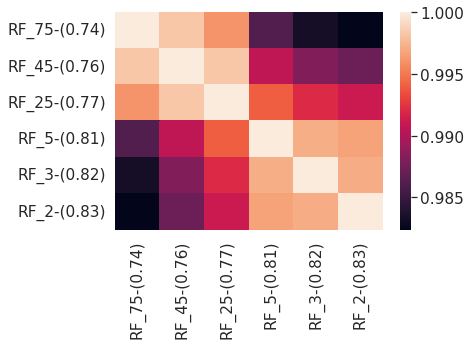

In [154]:
# pairwise-correlation heatmaps for figuring out what is going on with the whole (no-effect-of-bias-variance-tradeoff on testing datasets) situation
import pandas as pd
import seaborn as sns

df_S_2648 = pd.DataFrame(
    {'RF_75-(0.74)': rf_75.predict(S_2648_X_aug[:,[0,4,5,7]]),
     'RF_45-(0.76)': rf_45.predict(S_2648_X_aug[:,[0,4,5,7]]),
     'RF_25-(0.77)': rf_25.predict(S_2648_X_aug[:,[0,4,5,7]]),
     'RF_5-(0.81)': rf_5.predict(S_2648_X_aug[:,[0,4,5,7]]),
     'RF_3-(0.82)': rf_3.predict(S_2648_X_aug[:,[0,4,5,7]]),
     'RF_2-(0.83)': rf_2.predict(S_2648_X_aug[:,[0,4,5,7]])
    })
corr = df_S_2648.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

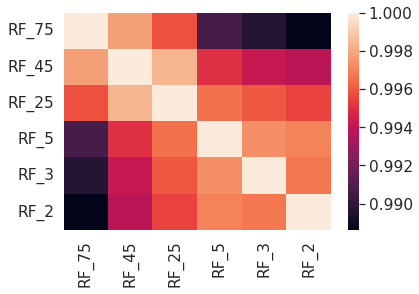

In [ ]:
# pairwise-correlation heatmaps for figuring out what is going on with the whole (no-effect-of-bias-variance-tradeoff on testing datasets) situation
import pandas as pd
import seaborn as sns

df_921 = pd.DataFrame(
    {'RF_75': rf_75.predict(S_921_X_aug[:,[0,4,5,7]]),
     'RF_45': rf_45.predict(S_921_X_aug[:,[0,4,5,7]]),
     'RF_25': rf_25.predict(S_921_X_aug[:,[0,4,5,7]]),
     'RF_5': rf_5.predict(S_921_X_aug[:,[0,4,5,7]]),
     'RF_3': rf_3.predict(S_921_X_aug[:,[0,4,5,7]]),
     'RF_2': rf_2.predict(S_921_X_aug[:,[0,4,5,7]])
    })
corr = df_921.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

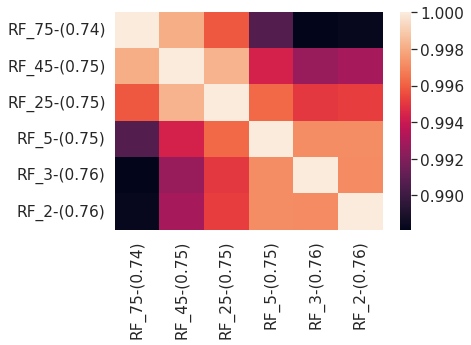

In [161]:
# pairwise-correlation heatmaps for figuring out what is going on with the whole (no-effect-of-bias-variance-tradeoff on testing datasets) situation
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'RF_75-(0.74)': rf_75.predict(Ssym_X_aug[:,[0,4,5,7]]),
     'RF_45-(0.75)': rf_45.predict(Ssym_X_aug[:,[0,4,5,7]]),
     'RF_25-(0.75)': rf_25.predict(Ssym_X_aug[:,[0,4,5,7]]),
     'RF_5-(0.75)': rf_5.predict(Ssym_X_aug[:,[0,4,5,7]]),
     'RF_3-(0.76)': rf_3.predict(Ssym_X_aug[:,[0,4,5,7]]),
     'RF_2-(0.76)': rf_2.predict(Ssym_X_aug[:,[0,4,5,7]])
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

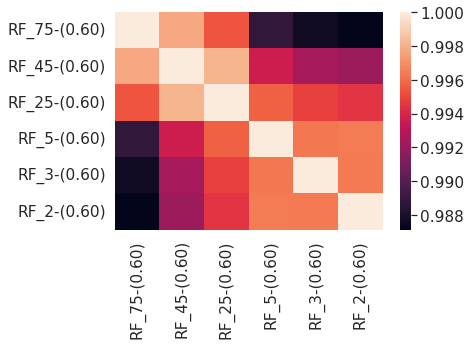

In [155]:
# pairwise-correlation heatmaps for figuring out what is going on with the whole (no-effect-of-bias-variance-tradeoff on testing datasets) situation
import pandas as pd
import seaborn as sns

df_S_669 = pd.DataFrame(
    {'RF_75-(0.60)': rf_75.predict(S_669_X_aug[:,[0,4,5,7]]),
     'RF_45-(0.60)': rf_45.predict(S_669_X_aug[:,[0,4,5,7]]),
     'RF_25-(0.60)': rf_25.predict(S_669_X_aug[:,[0,4,5,7]]),
     'RF_5-(0.60)': rf_5.predict(S_669_X_aug[:,[0,4,5,7]]),
     'RF_3-(0.60)': rf_3.predict(S_669_X_aug[:,[0,4,5,7]]),
     'RF_2-(0.60)': rf_2.predict(S_669_X_aug[:,[0,4,5,7]])
    })
corr = df_S_669.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
# trying to do a quick-dirty manual ensemble here among RF models with different depths
# print(pearsonr(S_2648_y,rf_2.predict(S_2648_X[:,[0,4,5,7]])))
print(pearsonr(S_921_y_aug,(rf_2.predict(S_921_X_aug[:,[0,4,5,7]])+rf_25.predict(S_921_X_aug[:,[0,4,5,7]])+rf_75.predict(S_921_X_aug[:,[0,4,5,7]]))/3))
print(pearsonr(S_669_y_aug,(rf_2.predict(S_669_X_aug[:,[0,4,5,7]])+rf_25.predict(S_669_X_aug[:,[0,4,5,7]])+rf_75.predict(S_669_X_aug[:,[0,4,5,7]]))/3))
print(pearsonr(Ssym_y_aug,(rf_2.predict(Ssym_X_aug[:,[0,4,5,7]])+rf_25.predict(Ssym_X_aug[:,[0,4,5,7]])+rf_75.predict(Ssym_X_aug[:,[0,4,5,7]]))/3))

(0.7406963927447158, 3.7045e-320)
(0.6030922154593708, 3.1056086919365657e-127)
(0.7498577903697052, 1.799356764094368e-124)


In [ ]:
# Now, add the four features one-by-one, and check how things change with respect to the different feature combinations
# A - P_DP (0)
# B - BACK_KL (4)
# C - W/M (7)
# D - Neighbor_Energy (2)
# E - Neighbor_Entropy (6)
# F - PSSM (5)

# the "feature_to_index_map" below will be used for generating combinations with letters, 
# and then converting those letters to indices for accessing the features from X arrays   
feature_to_index_map = {"A":0,
                        "B":4,
                        "C":7,
                        "D":2,
                        "E":6,
                        "F":5}

# In the "results_tracking_dict" below, outer-level keys will be dataset names, and values will be dictionaries
results_tracking_dict = {}
# In the inner dictionaries, keys will be feature-name alphabet representations separated by (+) between them, and values will be pearson correlations on both "direct" and "reverse" mutations 
results_tracking_dict["S_921"] = {}
results_tracking_dict["S_669"] = {}
results_tracking_dict["Ssym"] = {}
# In the "model_tracking_dict" below, keys will be feature-name alphabet representations separated by (+) between them, and values will be RF
# trained with the corresponding feature combination on S_2648 dataset  
model_tracking_dict = {}


from itertools import combinations
f_names = "ABCDEF"
one_combinations = list(combinations(f_names,1))
two_combinations = list(combinations(f_names,2))
three_combinations = list(combinations(f_names,3))
four_combinations = list(combinations(f_names,4))
five_combinations = list(combinations(f_names,5))
six_combinations = list(combinations(f_names,6))

# the four combination-lists will be concatenated, and ran through the same inner-loop below
feature_combinations = one_combinations + two_combinations + three_combinations + four_combinations + five_combinations + six_combinations
# the outer-loop will be for different feature combinations, and inner loop or even manually predictions for the three test datasets can be generated

for f_comb in feature_combinations:
    f_index_comb = [feature_to_index_map[i] for i in f_comb] 
    inner_key = str(["+".join([i for i in f_comb])][0])
    loc_rf = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,f_index_comb],S_2648_y_aug)

    results_tracking_dict["S_921"][inner_key] = pearsonr(S_921_y_aug,loc_rf.predict(S_921_X_aug[:,f_index_comb]))[0] 
    results_tracking_dict["S_669"][inner_key] = pearsonr(S_669_y_aug,loc_rf.predict(S_669_X_aug[:,f_index_comb]))[0]
    results_tracking_dict["Ssym"][inner_key] = pearsonr(Ssym_y_aug,loc_rf.predict(Ssym_X_aug[:,f_index_comb]))[0]

    model_tracking_dict[inner_key] = loc_rf

In [ ]:
# import pickle
# with open("feature_combo_result_dict.pickle","wb") as f:
#     pickle.dump(results_tracking_dict,f)

In [ ]:
# import pickle
# with open("feature_combo_model_dict.pickle","wb") as f:
#     pickle.dump(model_tracking_dict,f)

In [ ]:
# import pickle
# with open("feature_combo_result_dict.pickle","rb") as f:
#     results_tracking_dict = pickle.load(f)

In [ ]:
S_921_dataframe = pd.DataFrame.from_dict(results_tracking_dict['S_921'],orient="index",columns=["PCC"])
S_921_dataframe = S_921_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
S_921_dataframe["combo_length"] = [len(i) for i in list(S_921_dataframe.index)]
S_921_dataframe["combo_signature"] = [i for i in list(S_921_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (S_921_dataframe.groupby(["combo_length"])["PCC"].transform(max) == S_921_dataframe["PCC"])
S_921_max_results = S_921_dataframe[max_idx]
S_921_max_results

,PCC,combo_length,combo_signature
A,0.688,1,A
A+D,0.732,3,A+D
A+E+F,0.749,5,A+E+F
A+D+E+F,0.763,7,A+D+E+F
A+B+D+E+F,0.757,9,A+B+D+E+F
A+B+C+D+E+F,0.749,11,A+B+C+D+E+F


In [ ]:
S_669_dataframe = pd.DataFrame.from_dict(results_tracking_dict['S_669'],orient="index",columns=["PCC"])
S_669_dataframe = S_669_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
S_669_dataframe["combo_length"] = [len(i) for i in list(S_669_dataframe.index)]
S_669_dataframe["combo_signature"] = [i for i in list(S_669_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (S_669_dataframe.groupby(["combo_length"])["PCC"].transform(max) == S_669_dataframe["PCC"])
S_669_max_results = S_669_dataframe[max_idx]
S_669_max_results 

,PCC,combo_length,combo_signature
A,0.542,1,A
A+B,0.582,3,A+B
A+B+C,0.594,5,A+B+C
A+B+F,0.594,5,A+B+F
A+B+C+F,0.603,7,A+B+C+F
A+B+C+E+F,0.601,9,A+B+C+E+F
A+B+C+D+E+F,0.596,11,A+B+C+D+E+F


In [140]:
Ssym_dataframe = pd.DataFrame.from_dict(results_tracking_dict['Ssym'],orient="index",columns=["PCC"])
Ssym_dataframe = Ssym_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
Ssym_dataframe["combo_length"] = [len(i) for i in list(Ssym_dataframe.index)]
Ssym_dataframe["combo_signature"] = [i for i in list(Ssym_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (Ssym_dataframe.groupby(["combo_length"])["PCC"].transform(max) == Ssym_dataframe["PCC"])
Ssym_max_results = Ssym_dataframe[max_idx]
Ssym_max_results 

,PCC,combo_length,combo_signature
A,0.704,1,A
A+B,0.742,3,A+B
A+B+F,0.750,5,A+B+F
A+C+D,0.750,5,A+C+D
A+B+E+F,0.759,7,A+B+E+F
A+B+D+E+F,0.761,9,A+B+D+E+F
A+B+C+D+E+F,0.763,11,A+B+C+D+E+F


In [ ]:
# another level of de-correlation by holding out mutations from a specific number of proteins for each of the random forests, and take their ensemble prediction
# as the final prediction?

# for this, let us at first get the ids of all the S_2648 proteins from the corresponding two-level dict that are not in the corresponding proteins_to_skip_list
pdbIds_avail = []
n_muts = []
list_feature_importances = []
for prot,muts in list_two_level_dict[0].items():
    if prot not in list_proteins_to_skip[0]:
        for mut in muts:
            pdbIds_avail.append(prot)
            # adding second time for the reverse mutation, since we are trianing on a reverse-augmented version of S_2648
            pdbIds_avail.append(prot)
id_set = set(pdbIds_avail)
pdbIds_avail = np.array(pdbIds_avail)
number_of_proteins_in_the_validation_set = 100
# "n_ensemble" is the number of random forests to be trained on different protein-level mutant subsets
# the subsets will contain all the forward and reverse mutations from the same protein
n_ensemble = 20
# "rf_models" list will hold the models trained on different protein-level mutation subsets 
rf_models = []
for i in range(n_ensemble):
    cur_iteration_X = []
    cur_iteration_y = []
    val_proteins = random.sample(id_set, k=number_of_proteins_in_the_validation_set)
    val_indices = (np.where(np.isin(pdbIds_avail, val_proteins) == True))[0]
    for j,(X,y) in enumerate(zip(S_2648_X_aug,S_2648_y_aug)):
        if j not in val_indices:
            cur_iteration_X.append(X)
            cur_iteration_y.append(y)
    cur_iteration_X = np.array(cur_iteration_X)
    cur_iteration_y = np.array(cur_iteration_y)
    l_model = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2).fit(cur_iteration_X[:,[0,4,5,7]],cur_iteration_y)
    list_feature_importances.append(l_model.feature_importances_)
    rf_models.append(l_model)
    n_muts.append(len(cur_iteration_X))

In [ ]:
# Now, we just have to take ensemble predictions, and see how it goes.....TADAAAA

# the elements of these lists are going to be numpy arrays full of predictions 
# for the corresponding datasets made by each of the trained and saved RF models in the above cell
# S_2648_predictions = []
S_921_predictions = []
S_669_predictions = []
Ssym_predictions = []

for rf in rf_models:
    # S_2648_predictions.append()
    S_921_predictions.append(rf.predict(S_921_X_aug[:,[0,4,5,7]]))
    S_669_predictions.append(rf.predict(S_669_X_aug[:,[0,4,5,7]]))
    Ssym_predictions.append(rf.predict(Ssym_X_aug[:,[0,4,5,7]]))

In [ ]:
S_921_ensemble_predictions = np.mean(np.array(S_921_predictions),axis=0)
S_669_ensemble_predictions = np.mean(np.array(S_669_predictions),axis=0)
Ssym_ensemble_predictions = np.mean(np.array(Ssym_predictions),axis=0)

print(pearsonr(S_921_y_aug,S_921_ensemble_predictions))
print(pearsonr(S_669_y_aug,S_669_ensemble_predictions))
print(pearsonr(Ssym_y_aug,Ssym_ensemble_predictions))

(0.7458490825113072, 0.0)
(0.6050035542966613, 3.0548951027985216e-128)
(0.7376511411219245, 1.9122765221972597e-118)


In [ ]:
for i in range(n_ensemble-1):
    print(n_muts[i])
    # print(pearsonr(S_921_predictions[i],S_921_predictions[i+1]))
    print(pearsonr(S_921_predictions[i],S_921_y_aug))
    # print(pearsonr(S_669_predictions[i],S_669_predictions[i+1]))
    print(pearsonr(S_669_predictions[i],S_669_y_aug))
    print(pearsonr(Ssym_predictions[i],Ssym_y_aug))
    print(list_feature_importances[i])
    print(".........................................")

1032
(0.7284205350627649, 1.6963667647835685e-304)
(0.5309072314059097, 1.0657068894737856e-93)
(0.7466260649987378, 7.660932742431429e-123)
[0.61863318 0.14843108 0.09932358 0.13361215]
.........................................
674
(0.7289779579135394, 3.4442479896544355e-305)
(0.5818240679463105, 1.7917623625221843e-116)
(0.7051324506258294, 6.431279281957485e-104)
[0.5297195  0.21342067 0.16242668 0.09443315]
.........................................
438
(0.6442075728510805, 1.7425743455374946e-216)
(0.5730142266189971, 3.037027201474527e-112)
(0.6626416659347654, 1.082250444923534e-87)
[0.23893246 0.19976294 0.27900052 0.28230409]
.........................................
1068
(0.7324502328855831, 1.529705991600633e-309)
(0.6027945781131337, 4.450084853193496e-127)
(0.7148264266033609, 4.9138666632861474e-108)
[0.49515206 0.20032195 0.16266951 0.14185648]
.........................................
962
(0.7026156407022994, 3.1803543270180585e-274)
(0.603316058287425, 2.36891331343525

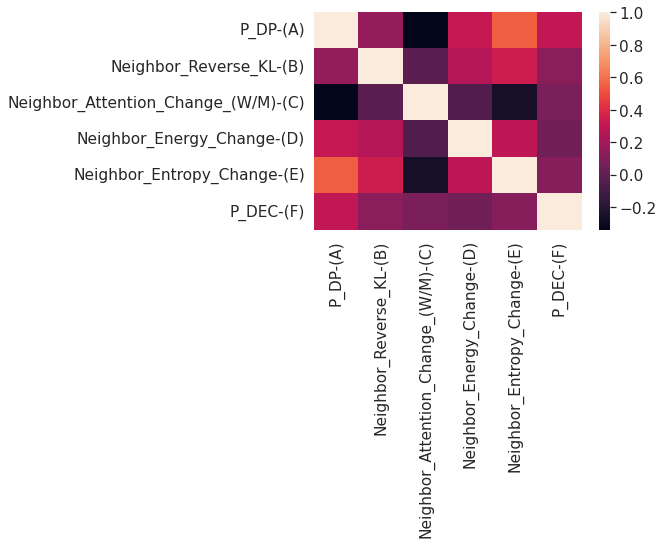

In [201]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP-(A)': Ssym_X[:,0],
     'Neighbor_Reverse_KL-(B)' : Ssym_X[:,4],
     'Neighbor_Attention_Change_(W/M)-(C)' : Ssym_X[:,7],
     'Neighbor_Energy_Change-(D)' : Ssym_X[:,2],
     'Neighbor_Entropy_Change-(E)' : Ssym_X[:,6],
     'P_DEC-(F)': Ssym_X[:,5], 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

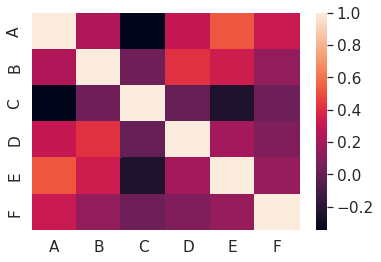

In [205]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'A': S_2648_X[:,0],
     'B' : S_2648_X[:,4],
     'C' : S_2648_X[:,7],
     'D' : S_2648_X[:,2],
     'E' : S_2648_X[:,6],
     'F': S_2648_X[:,5] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': S_2648_X[:,0],
     'P_DEC': S_2648_X[:,5],
     'Neighbor_Reverse_KL' : S_2648_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : S_2648_X[:,7],
     'Neighbor_Energy_Change' : S_2648_X[:,2],
     'Neighbor_Entropy_Change' : S_2648_X[:,6] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

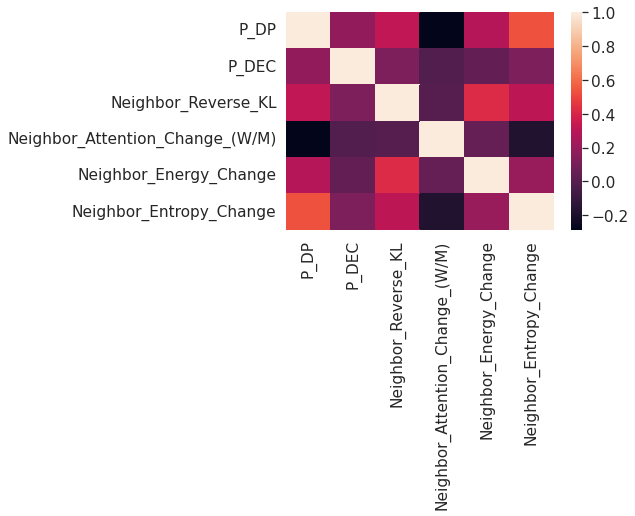

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': S_669_X[:,0],
     'P_DEC': S_669_X[:,5],
     'Neighbor_Reverse_KL' : S_669_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : S_669_X[:,7],
     'Neighbor_Energy_Change' : S_669_X[:,2],
     'Neighbor_Entropy_Change' : S_669_X[:,6] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

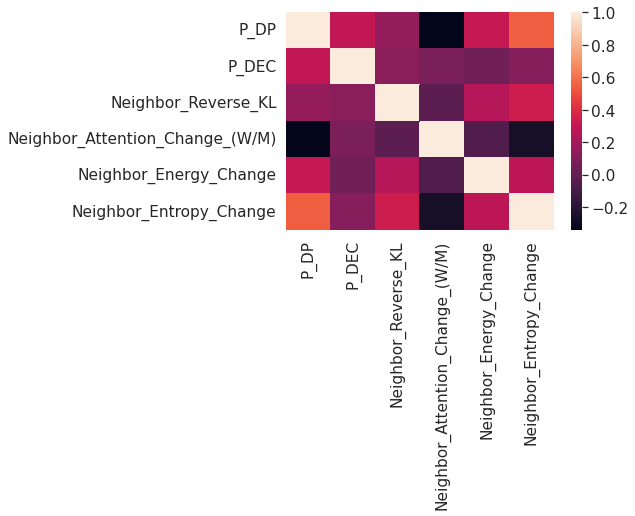

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': Ssym_X[:,0],
     'P_DEC': Ssym_X[:,5],
     'Neighbor_Reverse_KL' : Ssym_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : Ssym_X[:,7],
     'Neighbor_Energy_Change' : Ssym_X[:,2],
     'Neighbor_Entropy_Change' : Ssym_X[:,6] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

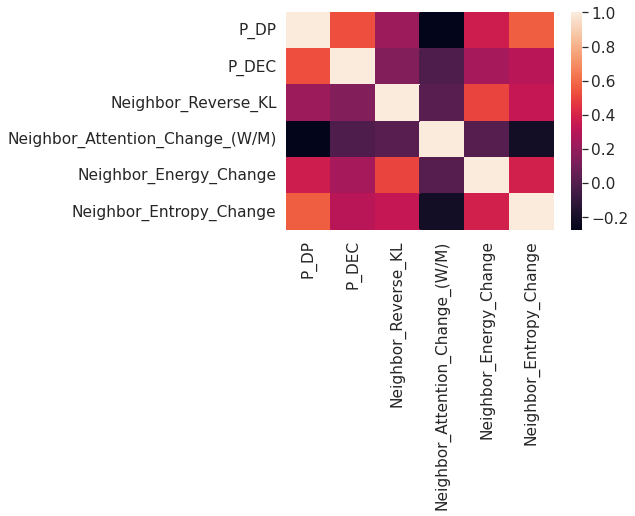

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': S_921_X[:,0],
     'P_DEC': S_921_X[:,5],
     'Neighbor_Reverse_KL' : S_921_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : S_921_X[:,7],
     'Neighbor_Energy_Change' : S_921_X[:,2],
     'Neighbor_Entropy_Change' : S_921_X[:,6]
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
# let us now do a final analysis to see if correlations of the four features on S_2648 are good coefficients
# but the problem is that, correlation changes based on subset of data chosen

# let us do a quick stochastic-hill-climbing with individual correlations constituting the initial solution 
# out target is to see how far the co-efficients move away from correlations
# this can in someway also be used for checking the underlying co-variate shift

# objective-function
# we are expecting "X" to be a numpy array of shape (number_of_samples,n_features) 
# and "coefficients" to be another numpy array of shape (1,n_features)
def objective(X, y, coefficients):
    # generate predictions for dataset
    yhat = (X*coefficients).sum(axis=-1)
    # calculate accuracy
    # taking negative of correlation because the "hillclimbing" function written below was intended to
    # minimize the objective function, and I do not want to tinker around with it at that level right now
    score = -1*(pearsonr(y,yhat)[0])
    return score

# hill climbing local search algorithm
def hillclimbing(X, y, solution, n_iter, step_size):
	# evaluate the initial point
	solution_eval = objective(X, y, solution)
	# run the hill climb
	for i in range(n_iter):
		# take a step
		candidate = solution + np.random.randn(len(solution)) * step_size
		# evaluate candidate point
		candidte_eval = objective(X, y, candidate)
		# check if we should keep the new point
		if candidte_eval <= solution_eval:
			# store the new point
			solution, solution_eval = candidate, candidte_eval
			# report progress
			print('>%d %.5f' % (i, solution_eval))
	return [solution, solution_eval]

hillclimbing(X=S_669_X[:,[0,4,5,7]],y=S_669_y,solution=(np.array([0.50,0.20,0.20,0.10]).reshape(1,-1)),n_iter=40000,step_size=0.00001)